# Prediction Results with Audio Annotations

**Last Modified**: Jul 29, 2025

In this notebook, we summarize and visualize the results for behavior classification with audio annotations. The training and testing data splits are created randomly for this experiment. We conduct hyperparameter tuning and look at the prediction results f the best performing model.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# System & OS

import sys
import os
import time
import warnings
import random
import psutil
import json
sys.path.append('../')
sys.path.append('../../')

import numpy as np
import pandas as pd
from tqdm import tqdm

# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader

# Script imports
from src.utils.io import (get_results_path,
                          get_project_root,
                          get_metadata_path,
                          get_video_labels_path,
                          get_audio_labels_path,
                            get_figures_dir,
                            get_matched_data_path,
                            get_matched_metadata_path)

from src.utils.plots import(multi_label_predictions)

from config.settings import (RAW_COLLAPSE_BEHAVIORS_MAPPING,
                             RAW_BEHAVIORS,
                             id_mapping)

from src.utils.data_prep import (adjust_behavior_and_durations,
                                 combined_annotations)

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.preprocessing import LabelEncoder

device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Graphing Parameters
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams["axes.labelsize"] = 30
mpl.rcParams['legend.fontsize'] = 30
mpl.rcParams['axes.titlesize'] = 35
mpl.rcParams['text.usetex'] = False
# plt.rcParams['font.family'] = 'serif'

In [3]:
acc_data = pd.read_csv(get_matched_data_path())
acc_data_metadata = pd.read_csv(get_matched_metadata_path())

acc_data['acc_x'] = acc_data['acc_x'].apply(json.loads)
acc_data['acc_y'] = acc_data['acc_y'].apply(json.loads)
acc_data['acc_z'] = acc_data['acc_z'].apply(json.loads)

acc_data = adjust_behavior_and_durations(acc_data, RAW_COLLAPSE_BEHAVIORS_MAPPING, RAW_BEHAVIORS)
acc_data_metadata = acc_data_metadata.loc[acc_data.index]

acc_data.reset_index()
acc_data_metadata.reset_index()

# Group and sum durations in hours
duration_table = acc_data.groupby(['Source', 'behavior'])['duration'].sum().div(3600)

# Convert to a pivot table: behaviors as rows, sources as columns
duration_df = duration_table.unstack(fill_value=0)

# Add a row for total duration per source
duration_df.loc['Total'] = duration_df.sum()

print(duration_df)

behavior   Feeding    Moving    Resting   Running   Vigilant
Source                                                      
Audio     0.406941  1.559753   0.000000  1.141878   0.000000
Video     1.318418  1.670032  51.570669  0.093556  16.445003
Total     1.725360  3.229784  51.570669  1.235434  16.445003


In [4]:
# load matched acceleration and label pairs data, metadata, and summary

all_annotations = combined_annotations(video_path=get_video_labels_path(), 
                                        audio_path=get_audio_labels_path(),
                                        id_mapping=id_mapping) # load annotations 

all_annotations.Timestamp_start = pd.to_datetime(all_annotations.Timestamp_start)
all_annotations.Timestamp_end = pd.to_datetime(all_annotations.Timestamp_end)
all_annotations['duration'] = (all_annotations.Timestamp_end - all_annotations.Timestamp_start).dt.total_seconds()

In [16]:
all_annotations.groupby(['Behavior', 'Source'])['duration'].sum()/3600

Behavior                  Source
Dig                       Video      0.004722
Drinking                  Video      0.020833
Eating                    Audio      0.575556
                          Video      1.488056
Head shake                Video      0.000000
Interaction               Video      0.437778
Jumping                   Video      0.000000
Large predator encounter  Video      0.000000
Lying (head down)         Video     62.351667
Lying (head up)           Video     13.074722
Marking (scent)           Video      0.553611
Rally                     Video      0.002222
Rolling                   Video      0.151944
Running                   Audio      2.220000
                          Video      0.172222
Scratching                Video      0.107778
Sitting                   Video      0.080000
Standing                  Video      5.381667
Time stamp changes        Video      0.016667
Trotting                  Audio      2.869167
                          Video      1.170000
U

## 1. Prediction Results without Trotting Behavior

In [6]:
label_encoder = LabelEncoder()
label_encoder.fit(RAW_BEHAVIORS)
experiment_name = 'no_split'

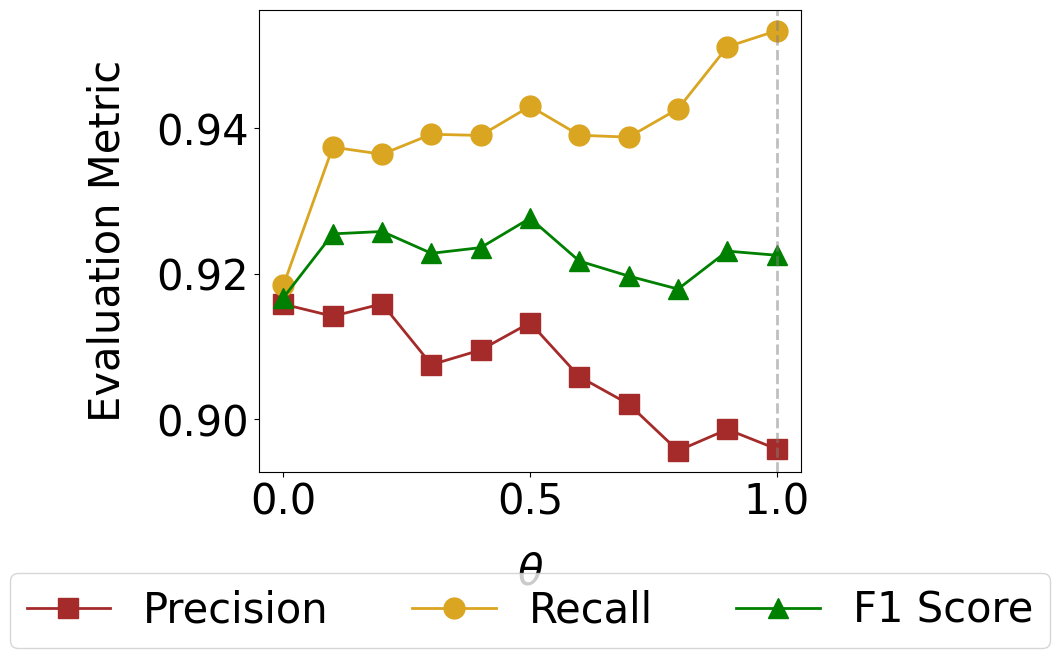

In [7]:
# you need to run 'scrpts/no_split.sh' for produce the hyperparameter finetuning plots.

thetas = 0.1*np.arange(11)
colors = ['brown', 'goldenrod', 'green']

precisions = np.zeros(len(thetas))
recalls = np.zeros(len(thetas))
f1scores = np.zeros(len(thetas))

for i, theta in enumerate(thetas):
    dir = get_results_path('no_split', 3, 64, 5, np.round(theta,1), 50, with_trotting=False)
    precisions[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
    recalls[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
    f1scores[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

plt.figure(figsize=(7,6))
plt.plot(thetas, precisions, color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(thetas, recalls, color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(thetas, f1scores, color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)
plt.axvline(1.0, color='grey', alpha=0.5, linestyle='--')
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)
plt.legend(loc='center', bbox_to_anchor=(.5, -0.3), ncol=3)
# plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

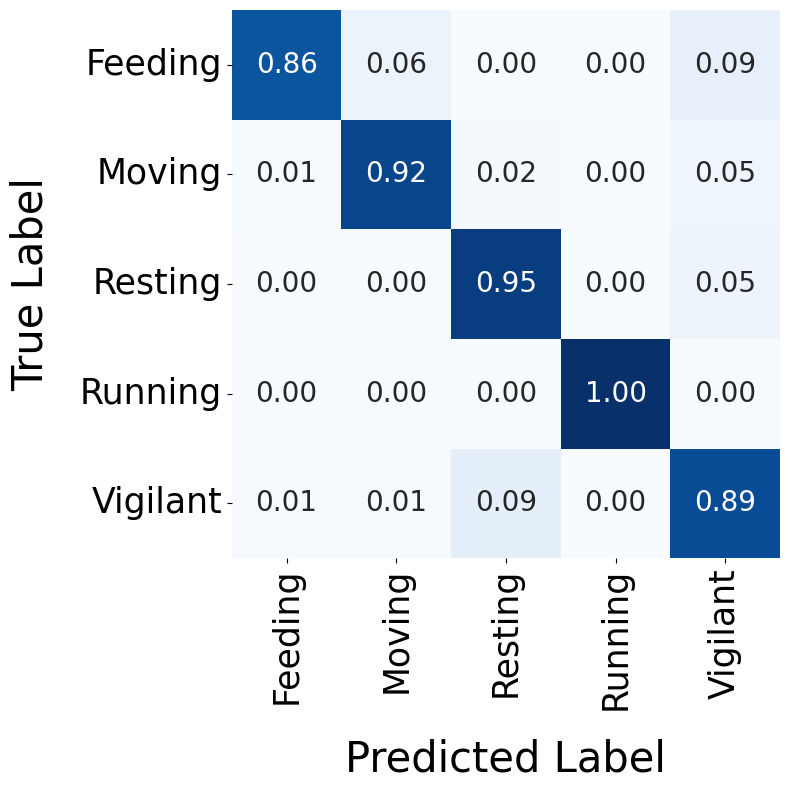

In [8]:
dir = get_results_path('no_split', 3, 64, 5, 0.0, 50, with_trotting=False)
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False)

<Figure size 640x480 with 0 Axes>

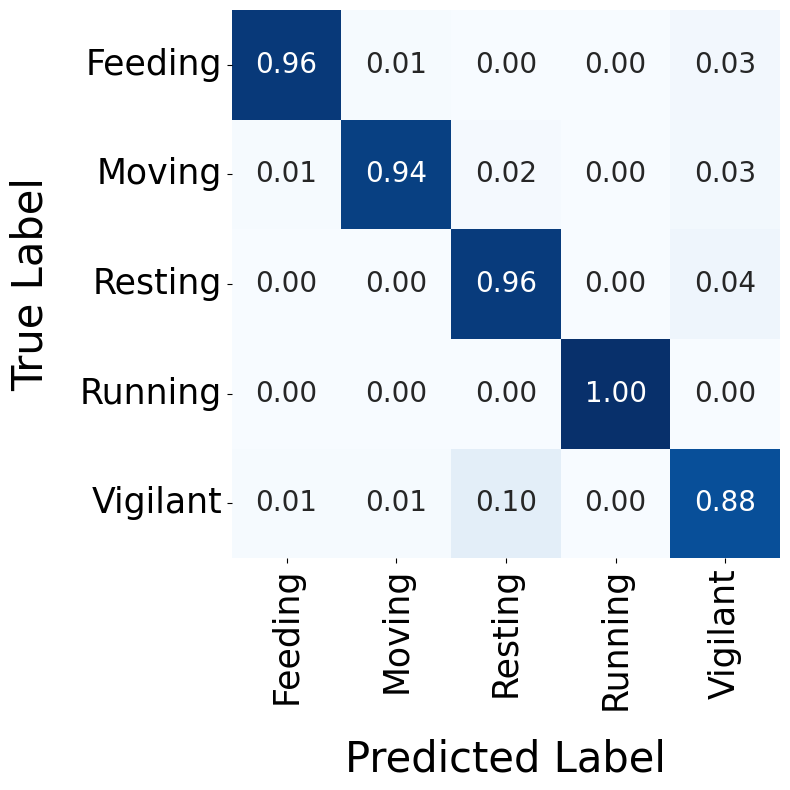

In [10]:
dir = get_results_path('no_split', 3, 64, 5, 0.5, 50, with_trotting=False)
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False)

## 2. Prediction Results with Trotting Behavior

In [36]:
label_encoder = LabelEncoder()
label_encoder.fit(RAW_BEHAVIORS_W_TROTTING)
experiment_name = 'no_split'

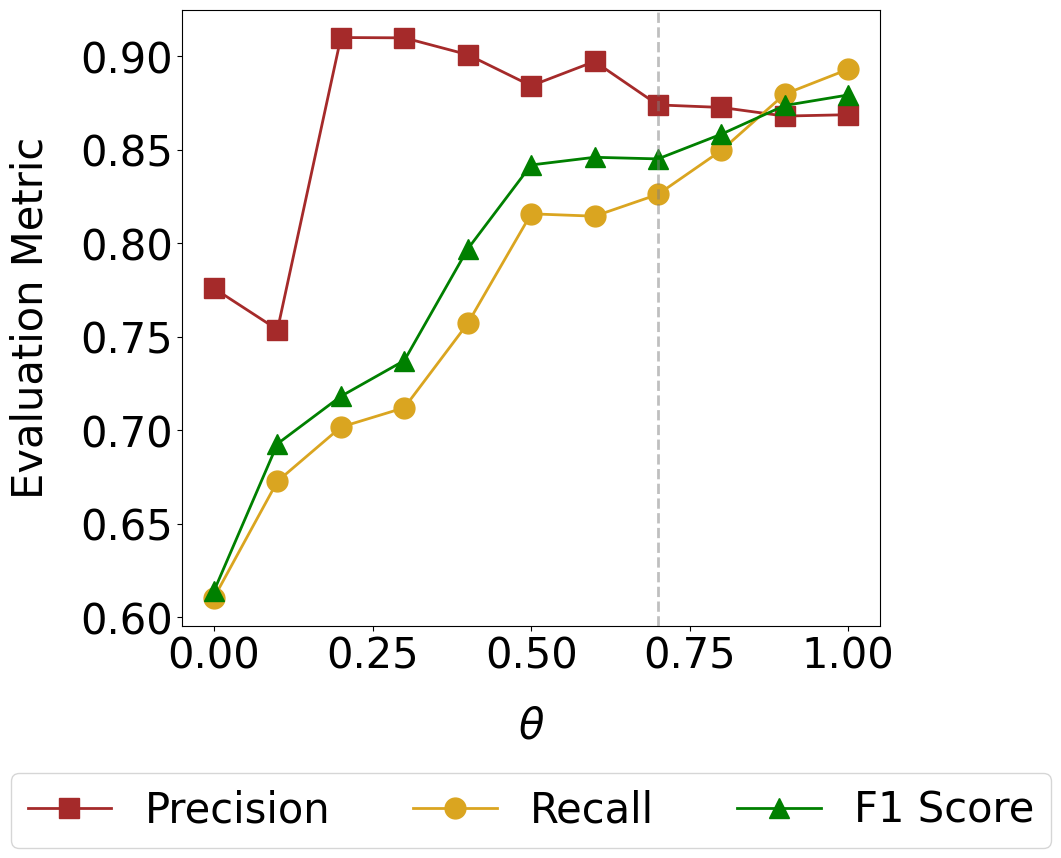

In [37]:
# you need to run 'scrpts/no_split.sh' for produce the hyperparameter finetuning plots.

thetas = 0.1*np.arange(11)
colors = ['brown', 'goldenrod', 'green']

precisions = np.zeros(len(thetas))
recalls = np.zeros(len(thetas))
f1scores = np.zeros(len(thetas))

for i, theta in enumerate(thetas):
    dir = get_results_path('no_split', 3, 64, 5, np.round(theta,1), 50, with_trotting=True)
    precisions[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
    recalls[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
    f1scores[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True)


plt.figure(figsize=(9,8))
plt.plot(thetas, precisions, color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(thetas, recalls, color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(thetas, f1scores, color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)
plt.axvline(0.7, color='grey', alpha=0.5, linestyle='--')
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)
plt.legend(loc='center', bbox_to_anchor=(.5, -0.3), ncol=3)
# plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

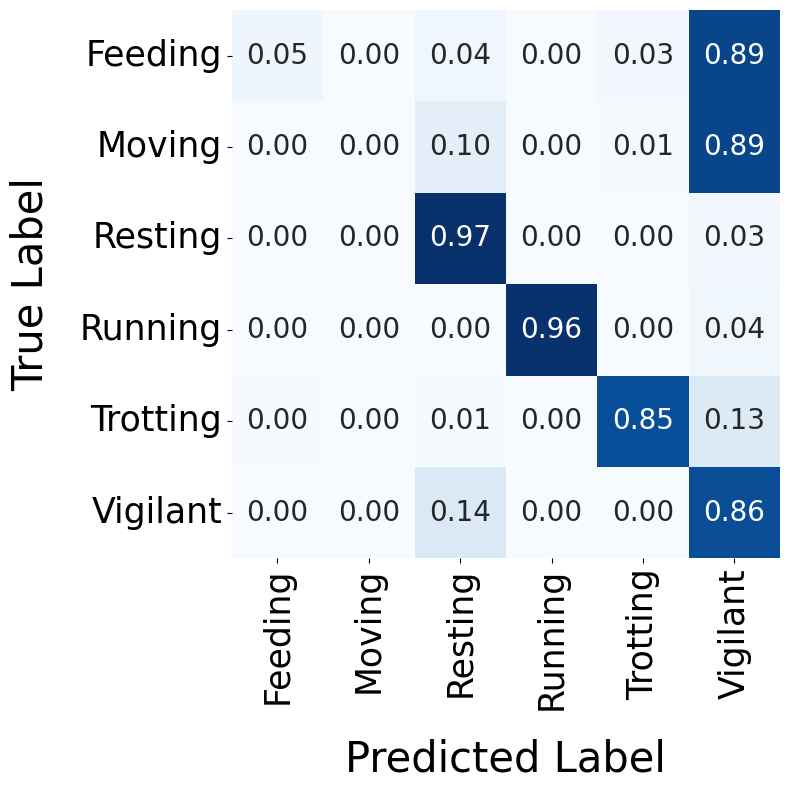

In [38]:
dir = get_results_path('no_split', 3, 64, 5, 0.0, 50, with_trotting=True)
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False)

<Figure size 640x480 with 0 Axes>

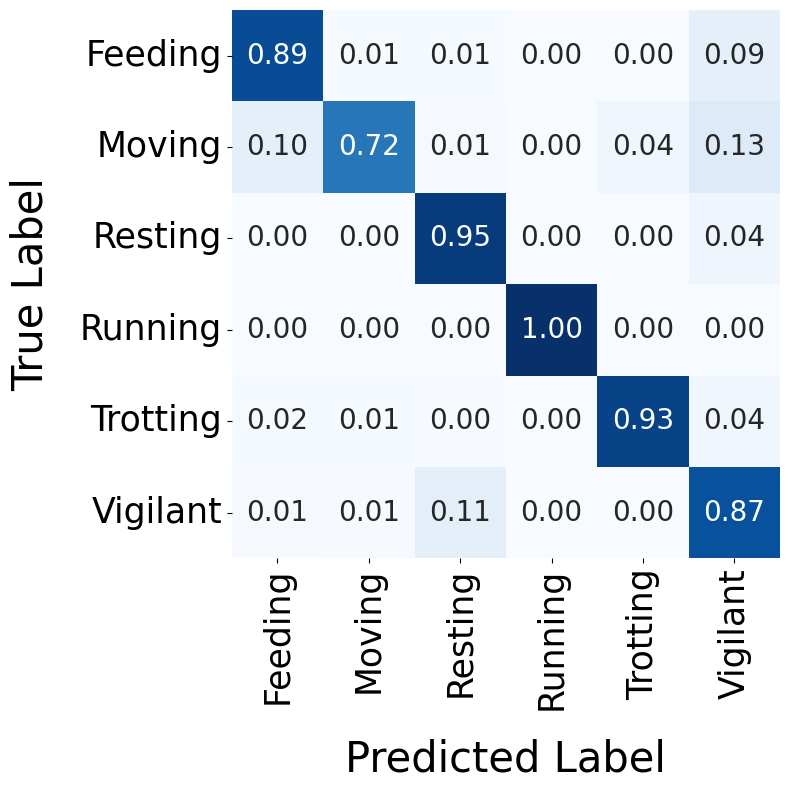

In [39]:
dir = get_results_path('no_split', 3, 64, 5, 1.0, 50, with_trotting=True)
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False)